# Neo4j Knowledge Graph Learning Notebook

This notebook will help you learn Neo4j by creating a sample knowledge graph with dummy data.
We'll cover connections to both local Neo4j instances and Neo4j Aura.

## Prerequisites
- Install required packages: `pip install neo4j pandas matplotlib seaborn`
- Neo4j instance running locally OR Neo4j Aura instance


In [1]:
# Install required packages
!pip install neo4j pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [8]:
import os
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Database Connection Setup

Choose one of the connection methods below based on your setup.

In [14]:
class Neo4jConnection:
    def __init__(self, uri, user, password, database=None):
        self.uri = uri
        self.user = user
        self.password = password
        self.database = database
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        self.driver.close()
    
    def get_available_databases(self):
        """Get list of available databases"""
        try:
            with self.driver.session() as session:
                result = session.run("SHOW DATABASES")
                return [record["name"] for record in result if record["currentStatus"] == "online"]
        except Exception as e:
            print(f"Could not list databases: {e}")
            return ["neo4j"]  # Default fallback
    
    def run_query(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            result = session.run(query, parameters or {})
            return [record for record in result]
    
    def run_write_query(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            result = session.write_transaction(lambda tx: tx.run(query, parameters or {}))
            return result

In [44]:
# Connection Configuration
# Choose one of the following connection methods:

# Option 1: Local Neo4j (default setup)
LOCAL_URI = "bolt://localhost:7687"
LOCAL_USER = "neo4j"
LOCAL_PASSWORD = "M1C0ntrasen@"  # Change to your local password

# Option 2: Neo4j Aura (replace with your Aura credentials)
AURA_URI = "neo4j+s://your-instance.databases.neo4j.io"
AURA_USER = "neo4j"
AURA_PASSWORD = "e7ldDfSrG2uUojvyOZXF7FiAErq-TqQimWZcBY0GN3w"

# Select connection type (change to 'aura' for Aura connection)
connection_type = 'aura'  # or 'aura' or 'local

# First, establish basic connection to detect databases
if connection_type == 'local':
    temp_conn = Neo4jConnection(LOCAL_URI, LOCAL_USER, LOCAL_PASSWORD)
    print("Connected to local Neo4j instance")
else:
    temp_conn = Neo4jConnection(AURA_URI, AURA_USER, AURA_PASSWORD)
    print("Connected to Neo4j Aura instance")

# Detect available databases
try:
    available_databases = temp_conn.get_available_databases()
    print(f"Available databases: {available_databases}")
    
    # Choose the first available database (usually 'neo4j' or 'system')
    target_database = None
    for db_name in ['neo4j', 'movies', 'system']:
        if db_name in available_databases:
            target_database = db_name
            break
    
    if not target_database:
        target_database = available_databases[0] if available_databases else 'neo4j'
    
    print(f"Using database: {target_database}")
    
    # Close temporary connection and create new one with specific database
    temp_conn.close()
    
    if connection_type == 'local':
        conn = Neo4jConnection(LOCAL_URI, LOCAL_USER, LOCAL_PASSWORD, target_database)
    else:
        conn = Neo4jConnection(AURA_URI, AURA_USER, AURA_PASSWORD, target_database)
    
    # Test connection with specific database
    result = conn.run_query("RETURN 'Connection successful!' as message")
    print(f"Test result: {result[0]['message']}")
    
except Exception as e:
    print(f"Connection failed: {e}")
    print("\\nTroubleshooting tips:")
    print("1. Make sure Neo4j is running (check http://localhost:7474)")
    print("2. Verify your username and password")
    print("3. For Aura, check your connection string and credentials")
    print("4. Try using 'system' database by running: USE system")
    temp_conn.close()

Connected to Neo4j Aura instance
Could not list databases: Cannot resolve address your-instance.databases.neo4j.io:7687
Available databases: ['neo4j']
Using database: neo4j
Connection failed: Cannot resolve address your-instance.databases.neo4j.io:7687
\nTroubleshooting tips:
1. Make sure Neo4j is running (check http://localhost:7474)
2. Verify your username and password
3. For Aura, check your connection string and credentials
4. Try using 'system' database by running: USE system


In [12]:
# Alternative: Manual database selection (run this if automatic detection fails)
# Uncomment and run this cell to manually specify a database

# manual_database = "system"  # Try "system", "movies", or other available databases
# 
# if connection_type == 'local':
#     conn = Neo4jConnection(LOCAL_URI, LOCAL_USER, LOCAL_PASSWORD, manual_database)
# else:
#     conn = Neo4jConnection(AURA_URI, AURA_USER, AURA_PASSWORD, manual_database)
# 
# try:
#     result = conn.run_query("RETURN 'Manual connection successful!' as message")
#     print(f"Manual connection test: {result[0]['message']}")
#     print(f"Using database: {manual_database}")
# except Exception as e:
#     print(f"Manual connection failed: {e}")

## 2. Clear Existing Data (Optional)

Run this cell if you want to start with a clean database.

In [17]:
# Clear all nodes and relationships (use with caution!)
clear_db = input("Do you want to clear the database? (yes/no): ")
if clear_db.lower() == 'yes':
    conn.run_query("MATCH (n) DETACH DELETE n")
    print("Database cleared!")
else:
    print("Database not cleared.")

Do you want to clear the database? (yes/no):  yes


Database cleared!


## 3. Create Sample Knowledge Graph: Tech Company Dataset

We'll create a knowledge graph representing:
- **People** (employees)
- **Companies** 
- **Technologies**
- **Projects**
- **Skills**

With relationships like:
- WORKS_FOR
- KNOWS (technology/skill)
- WORKED_ON (project)
- USES (technology in project)
- COLLABORATES_WITH

In [18]:
# Create constraints for unique properties
constraints = [
    "CREATE CONSTRAINT person_email IF NOT EXISTS FOR (p:Person) REQUIRE p.email IS UNIQUE",
    "CREATE CONSTRAINT company_name IF NOT EXISTS FOR (c:Company) REQUIRE c.name IS UNIQUE",
    "CREATE CONSTRAINT technology_name IF NOT EXISTS FOR (t:Technology) REQUIRE t.name IS UNIQUE",
    "CREATE CONSTRAINT project_name IF NOT EXISTS FOR (pr:Project) REQUIRE pr.name IS UNIQUE"
]

for constraint in constraints:
    try:
        conn.run_query(constraint)
        print(f"Created constraint: {constraint.split()[2]}")
    except Exception as e:
        print(f"Constraint may already exist: {e}")

Created constraint: person_email
Created constraint: company_name
Created constraint: technology_name
Created constraint: project_name


In [19]:
# Sample data generation
companies = [
    {"name": "TechCorp", "industry": "Software", "founded": 2010, "employees": 500},
    {"name": "DataWorks", "industry": "Analytics", "founded": 2015, "employees": 200},
    {"name": "CloudFlow", "industry": "Cloud Services", "founded": 2018, "employees": 150},
    {"name": "AIVentures", "industry": "Artificial Intelligence", "founded": 2020, "employees": 80}
]

technologies = [
    {"name": "Python", "category": "Programming Language", "popularity": 9.5},
    {"name": "JavaScript", "category": "Programming Language", "popularity": 9.0},
    {"name": "Neo4j", "category": "Database", "popularity": 7.5},
    {"name": "React", "category": "Frontend Framework", "popularity": 8.5},
    {"name": "Docker", "category": "Containerization", "popularity": 8.0},
    {"name": "Kubernetes", "category": "Orchestration", "popularity": 7.8},
    {"name": "TensorFlow", "category": "Machine Learning", "popularity": 8.2},
    {"name": "AWS", "category": "Cloud Platform", "popularity": 9.2}
]

people = [
    {"name": "Alice Johnson", "email": "alice@techcorp.com", "role": "Senior Developer", "experience": 8},
    {"name": "Bob Smith", "email": "bob@dataworks.com", "role": "Data Scientist", "experience": 5},
    {"name": "Carol Davis", "email": "carol@cloudflow.com", "role": "DevOps Engineer", "experience": 6},
    {"name": "David Wilson", "email": "david@aiventures.com", "role": "ML Engineer", "experience": 4},
    {"name": "Eva Brown", "email": "eva@techcorp.com", "role": "Frontend Developer", "experience": 3},
    {"name": "Frank Miller", "email": "frank@dataworks.com", "role": "Backend Developer", "experience": 7},
    {"name": "Grace Lee", "email": "grace@cloudflow.com", "role": "Cloud Architect", "experience": 10},
    {"name": "Henry Taylor", "email": "henry@aiventures.com", "role": "Research Scientist", "experience": 12}
]

projects = [
    {"name": "Customer Analytics Platform", "status": "Active", "budget": 500000},
    {"name": "Mobile App Redesign", "status": "Completed", "budget": 200000},
    {"name": "Cloud Migration", "status": "Active", "budget": 800000},
    {"name": "AI Recommendation Engine", "status": "Planning", "budget": 1000000},
    {"name": "Real-time Dashboard", "status": "Active", "budget": 300000}
]

print("Sample data prepared!")
print(f"Companies: {len(companies)}")
print(f"Technologies: {len(technologies)}")
print(f"People: {len(people)}")
print(f"Projects: {len(projects)}")

Sample data prepared!
Companies: 4
Technologies: 8
People: 8
Projects: 5


In [20]:
# Create Company nodes
for company in companies:
    query = """
    CREATE (c:Company {
        name: $name,
        industry: $industry,
        founded: $founded,
        employees: $employees
    })
    """
    conn.run_query(query, company)

print("Created Company nodes")

Created Company nodes


In [21]:
# Create Technology nodes
for tech in technologies:
    query = """
    CREATE (t:Technology {
        name: $name,
        category: $category,
        popularity: $popularity
    })
    """
    conn.run_query(query, tech)

print("Created Technology nodes")

Created Technology nodes


In [22]:
# Create Project nodes
for project in projects:
    query = """
    CREATE (p:Project {
        name: $name,
        status: $status,
        budget: $budget
    })
    """
    conn.run_query(query, project)

print("Created Project nodes")

Created Project nodes


In [23]:
# Create Person nodes and WORKS_FOR relationships
company_assignments = {
    "alice@techcorp.com": "TechCorp",
    "eva@techcorp.com": "TechCorp",
    "bob@dataworks.com": "DataWorks",
    "frank@dataworks.com": "DataWorks",
    "carol@cloudflow.com": "CloudFlow",
    "grace@cloudflow.com": "CloudFlow",
    "david@aiventures.com": "AIVentures",
    "henry@aiventures.com": "AIVentures"
}

for person in people:
    company_name = company_assignments[person["email"]]
    query = """
    CREATE (p:Person {
        name: $name,
        email: $email,
        role: $role,
        experience: $experience
    })
    WITH p
    MATCH (c:Company {name: $company_name})
    CREATE (p)-[:WORKS_FOR {start_date: date('2020-01-01')}]->(c)
    """
    params = person.copy()
    params["company_name"] = company_name
    conn.run_query(query, params)

print("Created Person nodes and WORKS_FOR relationships")

Created Person nodes and WORKS_FOR relationships


In [24]:
# Create KNOWS relationships (Person -> Technology)
skill_assignments = {
    "Alice Johnson": ["Python", "JavaScript", "React", "Docker"],
    "Bob Smith": ["Python", "TensorFlow", "Neo4j", "AWS"],
    "Carol Davis": ["Docker", "Kubernetes", "AWS", "Python"],
    "David Wilson": ["Python", "TensorFlow", "Docker", "AWS"],
    "Eva Brown": ["JavaScript", "React", "Python"],
    "Frank Miller": ["Python", "JavaScript", "Neo4j", "Docker"],
    "Grace Lee": ["AWS", "Kubernetes", "Docker", "Python"],
    "Henry Taylor": ["Python", "TensorFlow", "Neo4j"]
}

for person_name, skills in skill_assignments.items():
    for skill in skills:
        proficiency = random.randint(6, 10)  # Random proficiency level
        query = """
        MATCH (p:Person {name: $person_name})
        MATCH (t:Technology {name: $skill})
        CREATE (p)-[:KNOWS {proficiency: $proficiency, years: $years}]->(t)
        """
        conn.run_query(query, {
            "person_name": person_name,
            "skill": skill,
            "proficiency": proficiency,
            "years": random.randint(1, 5)
        })

print("Created KNOWS relationships (Person -> Technology)")

Created KNOWS relationships (Person -> Technology)


In [25]:
# Create WORKED_ON relationships (Person -> Project)
project_assignments = {
    "Customer Analytics Platform": ["Bob Smith", "Frank Miller", "Alice Johnson"],
    "Mobile App Redesign": ["Eva Brown", "Alice Johnson"],
    "Cloud Migration": ["Carol Davis", "Grace Lee", "Frank Miller"],
    "AI Recommendation Engine": ["David Wilson", "Henry Taylor", "Bob Smith"],
    "Real-time Dashboard": ["Alice Johnson", "Eva Brown", "Frank Miller"]
}

for project_name, team_members in project_assignments.items():
    for person_name in team_members:
        role_in_project = random.choice(["Developer", "Lead", "Contributor", "Architect"])
        query = """
        MATCH (p:Person {name: $person_name})
        MATCH (pr:Project {name: $project_name})
        CREATE (p)-[:WORKED_ON {
            role: $role,
            start_date: date('2023-01-01'),
            contribution: $contribution
        }]->(pr)
        """
        conn.run_query(query, {
            "person_name": person_name,
            "project_name": project_name,
            "role": role_in_project,
            "contribution": random.randint(10, 90)
        })

print("Created WORKED_ON relationships (Person -> Project)")

Created WORKED_ON relationships (Person -> Project)


In [26]:
# Create USES relationships (Project -> Technology)
project_tech_stack = {
    "Customer Analytics Platform": ["Python", "Neo4j", "TensorFlow", "AWS"],
    "Mobile App Redesign": ["JavaScript", "React", "AWS"],
    "Cloud Migration": ["Docker", "Kubernetes", "AWS", "Python"],
    "AI Recommendation Engine": ["Python", "TensorFlow", "AWS", "Docker"],
    "Real-time Dashboard": ["JavaScript", "React", "Python", "AWS"]
}

for project_name, technologies in project_tech_stack.items():
    for tech in technologies:
        query = """
        MATCH (pr:Project {name: $project_name})
        MATCH (t:Technology {name: $tech})
        CREATE (pr)-[:USES {importance: $importance}]->(t)
        """
        conn.run_query(query, {
            "project_name": project_name,
            "tech": tech,
            "importance": random.choice(["High", "Medium", "Low"])
        })

print("Created USES relationships (Project -> Technology)")

Created USES relationships (Project -> Technology)


In [27]:
# Create COLLABORATES_WITH relationships (Person -> Person)
# People who worked on the same project collaborate with each other
query = """
MATCH (p1:Person)-[:WORKED_ON]->(project:Project)<-[:WORKED_ON]-(p2:Person)
WHERE p1 <> p2 AND NOT EXISTS((p1)-[:COLLABORATES_WITH]-(p2))
CREATE (p1)-[:COLLABORATES_WITH {projects_together: 1, since: date('2023-01-01')}]->(p2)
"""
conn.run_query(query)

print("Created COLLABORATES_WITH relationships")

Created COLLABORATES_WITH relationships


## 4. Basic Cypher Queries for Learning

Now let's explore the knowledge graph with various Cypher queries.

In [28]:
# Query 1: Get overview of the graph
overview_query = """
CALL apoc.meta.stats() YIELD labelCount, relTypeCount, propertyKeyCount, nodeCount, relCount
RETURN 
    nodeCount as total_nodes,
    relCount as total_relationships,
    labelCount as node_types,
    relTypeCount as relationship_types
"""

try:
    result = conn.run_query(overview_query)
    if result:
        stats = result[0]
        print("Graph Overview:")
        print(f"Total Nodes: {stats['total_nodes']}")
        print(f"Total Relationships: {stats['total_relationships']}")
        print(f"Node Types: {stats['node_types']}")
        print(f"Relationship Types: {stats['relationship_types']}")
except Exception as e:
    print("APOC procedures not available. Getting basic stats instead...")
    # Alternative query without APOC
    basic_stats = conn.run_query("MATCH (n) RETURN count(n) as total_nodes")
    rel_stats = conn.run_query("MATCH ()-[r]->() RETURN count(r) as total_relationships")
    print(f"Total Nodes: {basic_stats[0]['total_nodes']}")
    print(f"Total Relationships: {rel_stats[0]['total_relationships']}")

APOC procedures not available. Getting basic stats instead...
Total Nodes: 25
Total Relationships: 97


In [29]:
# Query 2: Find all people and their companies
query = """
MATCH (p:Person)-[:WORKS_FOR]->(c:Company)
RETURN p.name as person, p.role as role, c.name as company, c.industry as industry
ORDER BY c.name, p.name
"""

result = conn.run_query(query)
df_people = pd.DataFrame([dict(record) for record in result])
print("People and their Companies:")
print(df_people.to_string(index=False))

People and their Companies:
       person               role    company                industry
 David Wilson        ML Engineer AIVentures Artificial Intelligence
 Henry Taylor Research Scientist AIVentures Artificial Intelligence
  Carol Davis    DevOps Engineer  CloudFlow          Cloud Services
    Grace Lee    Cloud Architect  CloudFlow          Cloud Services
    Bob Smith     Data Scientist  DataWorks               Analytics
 Frank Miller  Backend Developer  DataWorks               Analytics
Alice Johnson   Senior Developer   TechCorp                Software
    Eva Brown Frontend Developer   TechCorp                Software


In [31]:
# Query 3: Find most popular technologies
query = """
MATCH (p:Person)-[k:KNOWS]->(t:Technology)
RETURN t.name as technology, 
       t.category as category,
       count(p) as people_count,
       avg(k.proficiency) as avg_proficiency,
       t.popularity as market_popularity
ORDER BY people_count DESC, avg_proficiency DESC
"""

result = conn.run_query(query)
df_tech = pd.DataFrame([dict(record) for record in result])
print("Technology Popularity in Our Dataset:")
print(df_tech.to_string(index=False))

Technology Popularity in Our Dataset:
technology             category  people_count  avg_proficiency  market_popularity
    Python Programming Language             8         8.125000                9.5
    Docker     Containerization             5         8.000000                8.0
       AWS       Cloud Platform             4         8.750000                9.2
JavaScript Programming Language             3         9.000000                9.0
TensorFlow     Machine Learning             3         8.333333                8.2
     Neo4j             Database             3         8.000000                7.5
     React   Frontend Framework             2         7.500000                8.5
Kubernetes        Orchestration             2         7.500000                7.8


In [32]:
# Query 4: Find project teams and their skills
query = """
MATCH (p:Person)-[:WORKED_ON]->(pr:Project)
OPTIONAL MATCH (p)-[:KNOWS]->(t:Technology)
RETURN pr.name as project,
       collect(DISTINCT p.name) as team_members,
       collect(DISTINCT t.name) as team_skills,
       pr.status as status,
       pr.budget as budget
ORDER BY pr.budget DESC
"""

result = conn.run_query(query)
print("Project Teams and Skills:")
for record in result:
    print(f"\nProject: {record['project']} (${record['budget']:,})")
    print(f"Status: {record['status']}")
    print(f"Team: {', '.join(record['team_members'])}")
    print(f"Skills: {', '.join(record['team_skills'][:10])}...")  # Show first 10 skills

Project Teams and Skills:

Project: AI Recommendation Engine ($1,000,000)
Status: Planning
Team: Bob Smith, David Wilson, Henry Taylor
Skills: Python, Neo4j, TensorFlow, AWS, Docker...

Project: Cloud Migration ($800,000)
Status: Active
Team: Carol Davis, Frank Miller, Grace Lee
Skills: Python, Docker, Kubernetes, AWS, JavaScript, Neo4j...

Project: Customer Analytics Platform ($500,000)
Status: Active
Team: Alice Johnson, Bob Smith, Frank Miller
Skills: Python, JavaScript, React, Docker, Neo4j, TensorFlow, AWS...

Project: Real-time Dashboard ($300,000)
Status: Active
Team: Alice Johnson, Eva Brown, Frank Miller
Skills: Python, JavaScript, React, Docker, Neo4j...

Project: Mobile App Redesign ($200,000)
Status: Completed
Team: Alice Johnson, Eva Brown
Skills: Python, JavaScript, React, Docker...


In [33]:
# Query 5: Find collaboration patterns
query = """
MATCH (p1:Person)-[:COLLABORATES_WITH]-(p2:Person)
MATCH (p1)-[:WORKS_FOR]->(c1:Company)
MATCH (p2)-[:WORKS_FOR]->(c2:Company)
RETURN p1.name as person1, 
       p2.name as person2,
       c1.name as company1,
       c2.name as company2,
       CASE WHEN c1.name = c2.name THEN 'Internal' ELSE 'Cross-Company' END as collaboration_type
ORDER BY collaboration_type, p1.name
"""

result = conn.run_query(query)
df_collab = pd.DataFrame([dict(record) for record in result])
print("Collaboration Patterns:")
print(df_collab.to_string(index=False))

Collaboration Patterns:
      person1       person2   company1   company2 collaboration_type
Alice Johnson     Bob Smith   TechCorp  DataWorks      Cross-Company
Alice Johnson     Bob Smith   TechCorp  DataWorks      Cross-Company
Alice Johnson  Frank Miller   TechCorp  DataWorks      Cross-Company
Alice Johnson  Frank Miller   TechCorp  DataWorks      Cross-Company
Alice Johnson  Frank Miller   TechCorp  DataWorks      Cross-Company
Alice Johnson  Frank Miller   TechCorp  DataWorks      Cross-Company
    Bob Smith Alice Johnson  DataWorks   TechCorp      Cross-Company
    Bob Smith Alice Johnson  DataWorks   TechCorp      Cross-Company
    Bob Smith  David Wilson  DataWorks AIVentures      Cross-Company
    Bob Smith  David Wilson  DataWorks AIVentures      Cross-Company
    Bob Smith  Henry Taylor  DataWorks AIVentures      Cross-Company
    Bob Smith  Henry Taylor  DataWorks AIVentures      Cross-Company
  Carol Davis  Frank Miller  CloudFlow  DataWorks      Cross-Company
  Carol Da

In [34]:
# Query 6: Find skill gaps in projects
query = """
MATCH (pr:Project)-[:USES]->(tech:Technology)
OPTIONAL MATCH (p:Person)-[:WORKED_ON]->(pr)
OPTIONAL MATCH (p)-[k:KNOWS]->(tech)
WITH pr, tech, 
     count(p) as team_size,
     count(k) as people_with_skill,
     avg(k.proficiency) as avg_skill_level
WHERE team_size > people_with_skill
RETURN pr.name as project,
       tech.name as technology,
       team_size,
       people_with_skill,
       (team_size - people_with_skill) as skill_gap,
       COALESCE(avg_skill_level, 0) as avg_proficiency
ORDER BY skill_gap DESC, project
"""

result = conn.run_query(query)
df_gaps = pd.DataFrame([dict(record) for record in result])
print("Skill Gaps in Projects:")
if not df_gaps.empty:
    print(df_gaps.to_string(index=False))
else:
    print("No significant skill gaps found in current projects!")

Skill Gaps in Projects:
                    project technology  team_size  people_with_skill  skill_gap  avg_proficiency
        Real-time Dashboard        AWS          3                  0          3              0.0
   AI Recommendation Engine     Docker          3                  1          2              7.0
Customer Analytics Platform TensorFlow          3                  1          2              8.0
Customer Analytics Platform        AWS          3                  1          2             10.0
        Mobile App Redesign        AWS          2                  0          2              0.0
   AI Recommendation Engine        AWS          3                  2          1             10.0
            Cloud Migration Kubernetes          3                  2          1              7.5
            Cloud Migration        AWS          3                  2          1              7.5
Customer Analytics Platform      Neo4j          3                  2          1              8.5
      

## 5. Advanced Queries and Analysis

In [35]:
# Advanced Query 1: Find shortest path between two people
query = """
MATCH path = shortestPath((p1:Person {name: 'Alice Johnson'})-[*]-(p2:Person {name: 'Henry Taylor'}))
RETURN [node in nodes(path) | 
    CASE 
        WHEN 'Person' IN labels(node) THEN node.name
        WHEN 'Company' IN labels(node) THEN 'Company: ' + node.name
        WHEN 'Project' IN labels(node) THEN 'Project: ' + node.name
        WHEN 'Technology' IN labels(node) THEN 'Tech: ' + node.name
        ELSE 'Unknown'
    END
] as connection_path,
length(path) as path_length
"""

result = conn.run_query(query)
if result:
    print("Shortest path between Alice Johnson and Henry Taylor:")
    print(f"Path length: {result[0]['path_length']}")
    print("Connection: " + " -> ".join(result[0]['connection_path']))
else:
    print("No path found between the specified people.")

Shortest path between Alice Johnson and Henry Taylor:
Path length: 2
Connection: Alice Johnson -> Tech: Python -> Henry Taylor


In [36]:
# Advanced Query 2: Find technology influencers (people who know popular technologies)
query = """
MATCH (p:Person)-[k:KNOWS]->(t:Technology)
WITH p, 
     count(t) as tech_count,
     avg(k.proficiency) as avg_proficiency,
     sum(t.popularity) as influence_score
MATCH (p)-[:WORKS_FOR]->(c:Company)
RETURN p.name as person,
       p.role as role,
       c.name as company,
       tech_count,
       round(avg_proficiency, 2) as avg_proficiency,
       round(influence_score, 2) as influence_score
ORDER BY influence_score DESC, avg_proficiency DESC
LIMIT 5
"""

result = conn.run_query(query)
df_influencers = pd.DataFrame([dict(record) for record in result])
print("Technology Influencers (Top 5):")
print(df_influencers.to_string(index=False))

Technology Influencers (Top 5):
       person             role    company  tech_count  avg_proficiency  influence_score
Alice Johnson Senior Developer   TechCorp           4             8.75             35.0
 David Wilson      ML Engineer AIVentures           4             8.50             34.9
    Grace Lee  Cloud Architect  CloudFlow           4             8.00             34.5
  Carol Davis  DevOps Engineer  CloudFlow           4             7.25             34.5
    Bob Smith   Data Scientist  DataWorks           4             8.75             34.4


## 6. Data Visualization

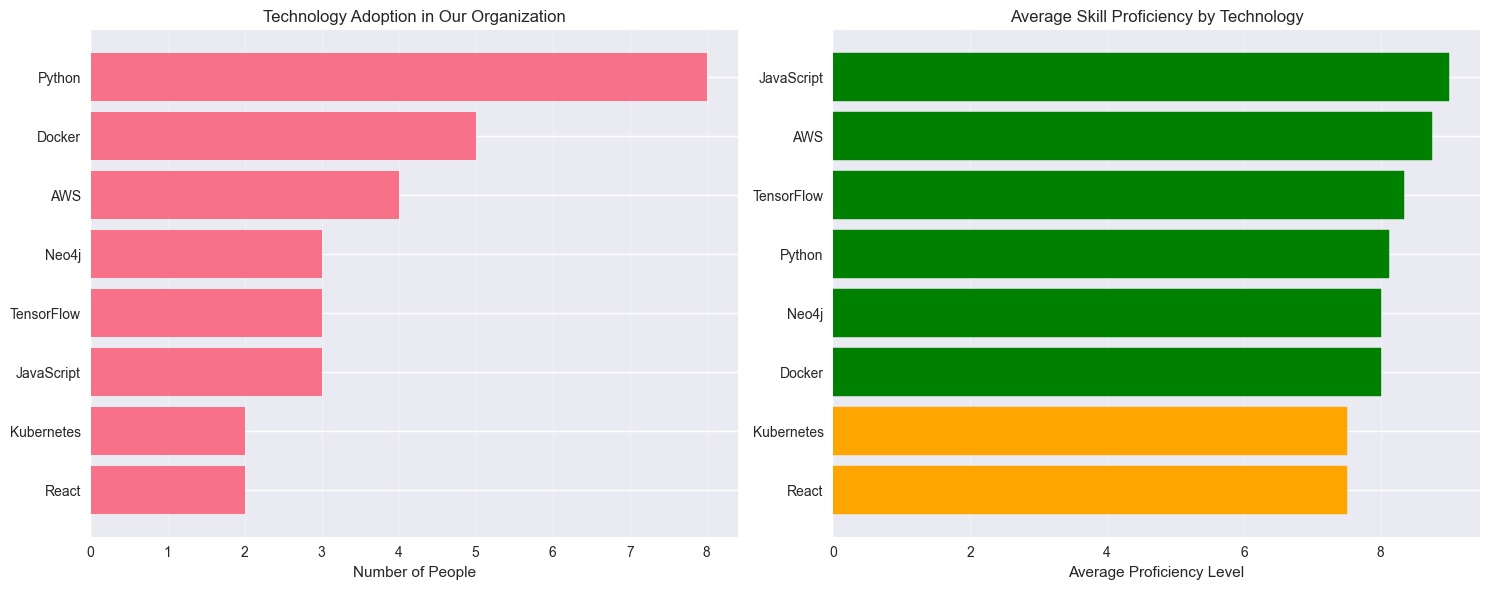

In [37]:
# Visualization 1: Technology popularity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: People count by technology
df_tech_sorted = df_tech.sort_values('people_count', ascending=True)
ax1.barh(df_tech_sorted['technology'], df_tech_sorted['people_count'])
ax1.set_xlabel('Number of People')
ax1.set_title('Technology Adoption in Our Organization')
ax1.grid(axis='x', alpha=0.3)

# Chart 2: Average proficiency by technology
df_tech_sorted2 = df_tech.sort_values('avg_proficiency', ascending=True)
bars = ax2.barh(df_tech_sorted2['technology'], df_tech_sorted2['avg_proficiency'])
ax2.set_xlabel('Average Proficiency Level')
ax2.set_title('Average Skill Proficiency by Technology')
ax2.grid(axis='x', alpha=0.3)

# Color bars based on proficiency level
for i, bar in enumerate(bars):
    proficiency = df_tech_sorted2.iloc[i]['avg_proficiency']
    if proficiency >= 8:
        bar.set_color('green')
    elif proficiency >= 7:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

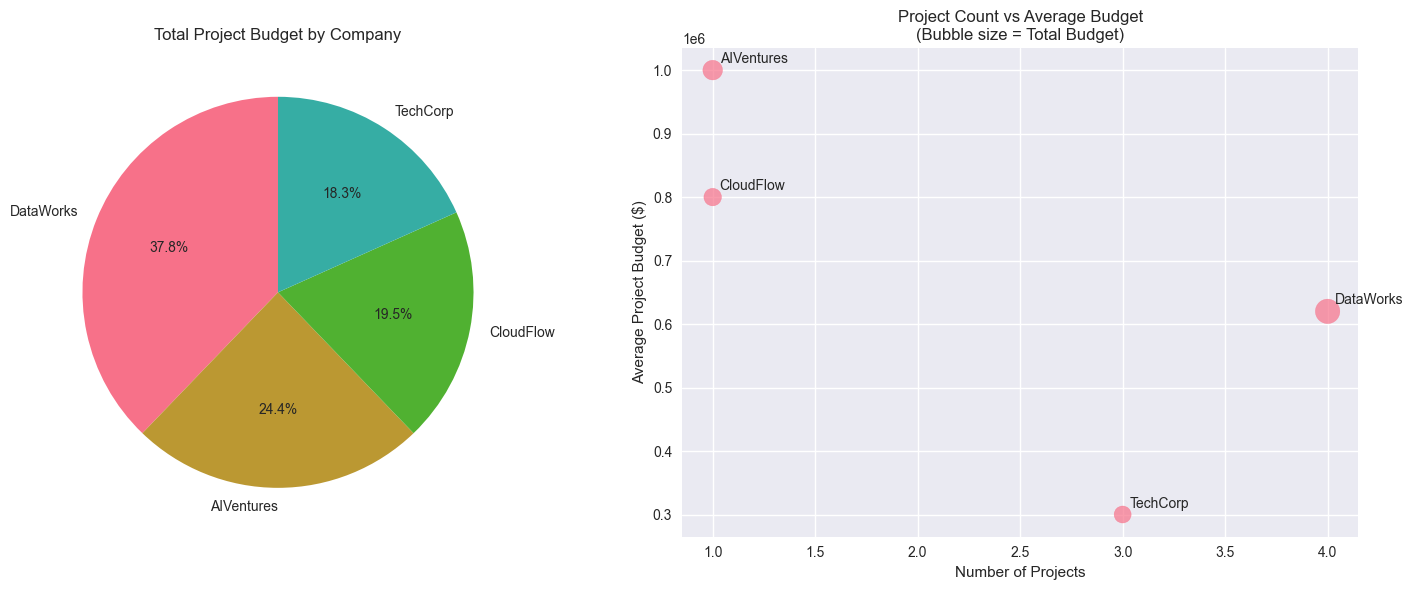

In [38]:
# Visualization 2: Company and project budget analysis
query = """
MATCH (c:Company)<-[:WORKS_FOR]-(p:Person)-[:WORKED_ON]->(pr:Project)
RETURN c.name as company, 
       count(DISTINCT pr) as projects_count,
       sum(pr.budget) as total_budget,
       avg(pr.budget) as avg_project_budget
ORDER BY total_budget DESC
"""

result = conn.run_query(query)
df_company_projects = pd.DataFrame([dict(record) for record in result])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Total budget by company
ax1.pie(df_company_projects['total_budget'], 
        labels=df_company_projects['company'],
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Total Project Budget by Company')

# Chart 2: Project count vs average budget
scatter = ax2.scatter(df_company_projects['projects_count'], 
                     df_company_projects['avg_project_budget'],
                     s=df_company_projects['total_budget']/10000,  # Size based on total budget
                     alpha=0.7)
ax2.set_xlabel('Number of Projects')
ax2.set_ylabel('Average Project Budget ($)')
ax2.set_title('Project Count vs Average Budget\n(Bubble size = Total Budget)')

# Add company labels
for i, company in enumerate(df_company_projects['company']):
    ax2.annotate(company, 
                (df_company_projects.iloc[i]['projects_count'], 
                 df_company_projects.iloc[i]['avg_project_budget']),
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

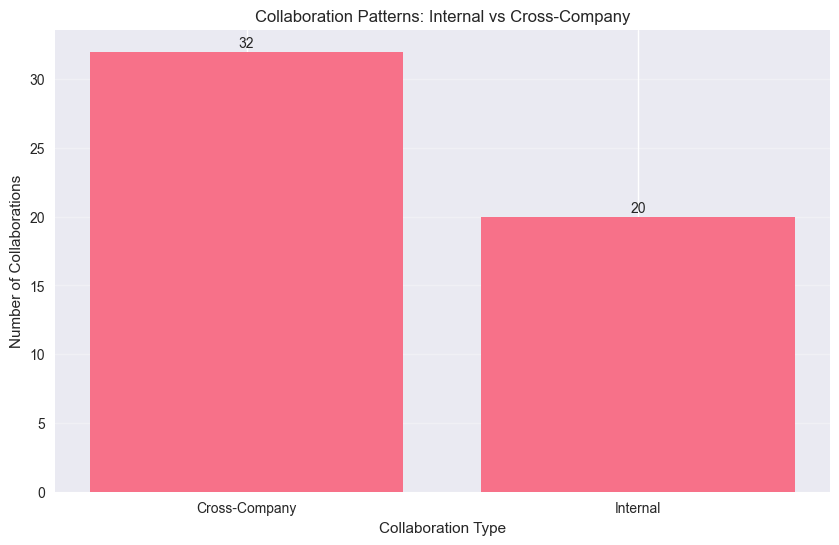

Internal collaborations: 20
Cross-company collaborations: 32


In [39]:
# Visualization 3: Collaboration network analysis
collaboration_summary = df_collab['collaboration_type'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(collaboration_summary.index, collaboration_summary.values)
plt.title('Collaboration Patterns: Internal vs Cross-Company')
plt.ylabel('Number of Collaborations')
plt.xlabel('Collaboration Type')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Internal collaborations: {collaboration_summary.get('Internal', 0)}")
print(f"Cross-company collaborations: {collaboration_summary.get('Cross-Company', 0)}")

## 7. Interactive Exploration Queries

Use these cells to run your own custom queries!

In [40]:
# Custom query cell - modify the query below to explore the data
custom_query = """
MATCH (p:Person)-[:KNOWS]->(t:Technology {name: 'Python'})
MATCH (p)-[:WORKS_FOR]->(c:Company)
RETURN p.name as person, p.role as role, c.name as company
ORDER BY p.name
"""

try:
    result = conn.run_query(custom_query)
    if result:
        df_custom = pd.DataFrame([dict(record) for record in result])
        print("Query Results:")
        print(df_custom.to_string(index=False))
    else:
        print("No results found.")
except Exception as e:
    print(f"Query error: {e}")

Query Results:
       person               role    company
Alice Johnson   Senior Developer   TechCorp
    Bob Smith     Data Scientist  DataWorks
  Carol Davis    DevOps Engineer  CloudFlow
 David Wilson        ML Engineer AIVentures
    Eva Brown Frontend Developer   TechCorp
 Frank Miller  Backend Developer  DataWorks
    Grace Lee    Cloud Architect  CloudFlow
 Henry Taylor Research Scientist AIVentures


In [41]:
# Practice Query 1: Find all technologies used in a specific project
project_name = "Customer Analytics Platform"  # Change this to explore different projects

query = f"""
MATCH (pr:Project {{name: '{project_name}'}})-[:USES]->(t:Technology)
RETURN t.name as technology, t.category as category
ORDER BY t.category, t.name
"""

result = conn.run_query(query)
print(f"Technologies used in '{project_name}':")
for record in result:
    print(f"- {record['technology']} ({record['category']})")

Technologies used in 'Customer Analytics Platform':
- AWS (Cloud Platform)
- Neo4j (Database)
- TensorFlow (Machine Learning)
- Python (Programming Language)


In [42]:
# Practice Query 2: Find people who could be good mentors (high proficiency in multiple technologies)
query = """
MATCH (p:Person)-[k:KNOWS]->(t:Technology)
WHERE k.proficiency >= 8
WITH p, count(t) as high_skill_count, avg(k.proficiency) as avg_proficiency
WHERE high_skill_count >= 2
MATCH (p)-[:WORKS_FOR]->(c:Company)
RETURN p.name as potential_mentor,
       p.role as role,
       c.name as company,
       high_skill_count as expert_technologies,
       round(avg_proficiency, 2) as avg_expertise_level
ORDER BY high_skill_count DESC, avg_proficiency DESC
"""

result = conn.run_query(query)
print("Potential Mentors (High proficiency in multiple technologies):")
for record in result:
    print(f"- {record['potential_mentor']} ({record['role']}) at {record['company']}")
    print(f"  Expert in {record['expert_technologies']} technologies with avg proficiency {record['avg_expertise_level']}")

Potential Mentors (High proficiency in multiple technologies):
- Alice Johnson (Senior Developer) at TechCorp
  Expert in 3 technologies with avg proficiency 9.33
- Bob Smith (Data Scientist) at DataWorks
  Expert in 3 technologies with avg proficiency 9.33
- David Wilson (ML Engineer) at AIVentures
  Expert in 3 technologies with avg proficiency 9.0
- Frank Miller (Backend Developer) at DataWorks
  Expert in 3 technologies with avg proficiency 8.67
- Grace Lee (Cloud Architect) at CloudFlow
  Expert in 2 technologies with avg proficiency 9.5
- Eva Brown (Frontend Developer) at TechCorp
  Expert in 2 technologies with avg proficiency 9.0
- Carol Davis (DevOps Engineer) at CloudFlow
  Expert in 2 technologies with avg proficiency 8.5
- Henry Taylor (Research Scientist) at AIVentures
  Expert in 2 technologies with avg proficiency 8.5


## 8. Summary and Next Steps

This notebook demonstrated:

1. **Connection Setup**: How to connect to both local Neo4j and Aura instances
2. **Data Modeling**: Creating a realistic knowledge graph with multiple node types and relationships
3. **Basic Queries**: Simple pattern matching and data retrieval
4. **Advanced Queries**: Path finding, aggregation, and analytical queries
5. **Visualization**: Creating charts and graphs from Neo4j data
6. **Interactive Exploration**: Custom queries for ongoing learning

### Key Neo4j Concepts Covered:
- **Nodes**: Entities (Person, Company, Technology, Project)
- **Relationships**: Connections with properties (WORKS_FOR, KNOWS, WORKED_ON, etc.)
- **Properties**: Attributes on nodes and relationships
- **Cypher**: Neo4j's query language
- **Patterns**: How to match and traverse the graph

### Suggested Next Steps:
1. Experiment with more complex queries
2. Add more data (locations, departments, certifications)
3. Try graph algorithms (if APOC is available)
4. Build a simple web application using this data
5. Explore Neo4j Bloom for visual graph exploration

In [43]:
# Clean up: Close the database connection
conn.close()
print("Database connection closed.")
print("\nThanks for exploring Neo4j! 🎉")
print("Feel free to modify and extend this notebook for your learning journey.")

Database connection closed.

Thanks for exploring Neo4j! 🎉
Feel free to modify and extend this notebook for your learning journey.
